In [2]:
import pandas as pd

# Load the training and testing datasets with specified encoding
train_data_path = '/imdb_tr.csv'
test_data_path = '/imdb_te.csv'

df_train = pd.read_csv(train_data_path, encoding='latin1')
df_test = pd.read_csv(test_data_path, encoding='latin1')

# Inspect the data
df_train.head(), df_test.head()



(   row_Number                                               text  polarity
 0        2148  first think another Disney movie, might good, ...         1
 1       23577  Put aside Dr. House repeat missed, Desperate H...         0
 2        1319  big fan Stephen King's work, film made even gr...         1
 3       13358  watched horrid thing TV. Needless say one movi...         0
 4        9495  truly enjoyed film. acting terrific plot. Jeff...         1,
    row_number                                               text
 0           0  Oh gosh!! I love movie sooooooooooooooooooooo ...
 1           1  I saw Borderline several years ago AMC. I've l...
 2           2  Let say GRANNY extremely well made horror viol...
 3           3  I like Full Moon Pictures I ordered movie USA,...
 4           4  Worst horror film ever funniest film ever roll...)

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Apply preprocessing
df_train['text'] = df_train['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Fit and transform on training data
X_train = tfidf.fit_transform(df_train['text']).toarray()
y_train = df_train['polarity']

# Transform testing data (only transform, no fitting)
X_test = tfidf.transform(df_test['text']).toarray()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model
model = Sequential([
    Dense(256, input_shape=(5000,), activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               1280256   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1313281 (5.01 MB)
Trainable params: 1313281 (5.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
625/6

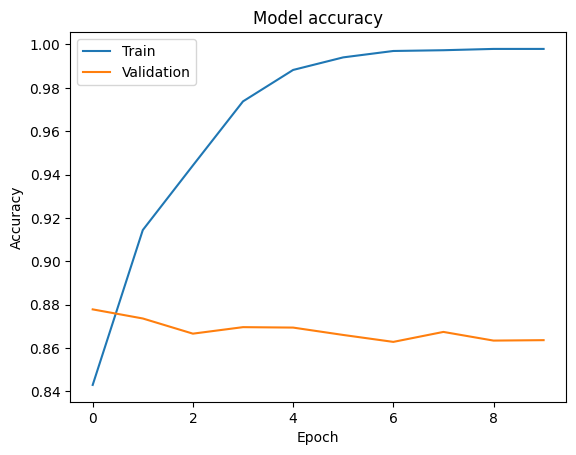

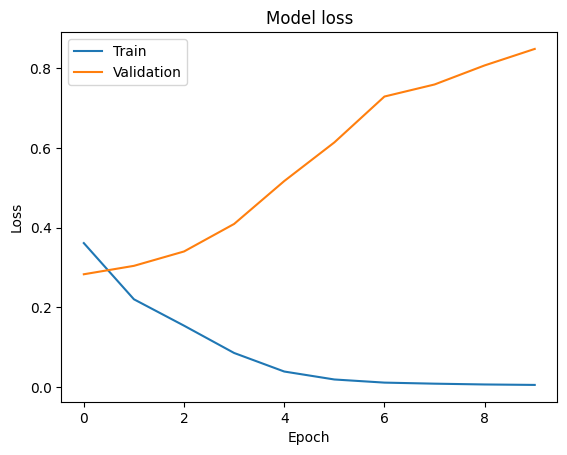

782/782 [==============================] - 5s 7ms/step
Predictions saved to imdb_test_predictions.csv


In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype("int32")

# Save predictions to a CSV file
df_test['predicted_polarity'] = y_pred
df_test.to_csv('/imdb_test_predictions.csv', index=False)

print("Predictions saved to imdb_test_predictions.csv")


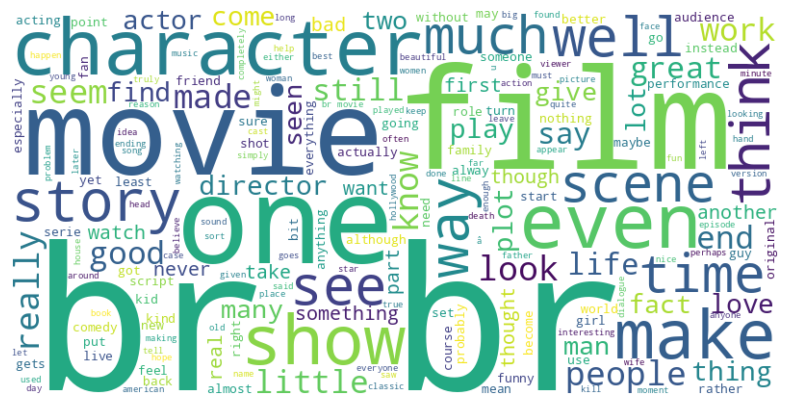

In [13]:
from wordcloud import WordCloud

# Combine all text from the training data
all_text = ' '.join(df_train['text'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


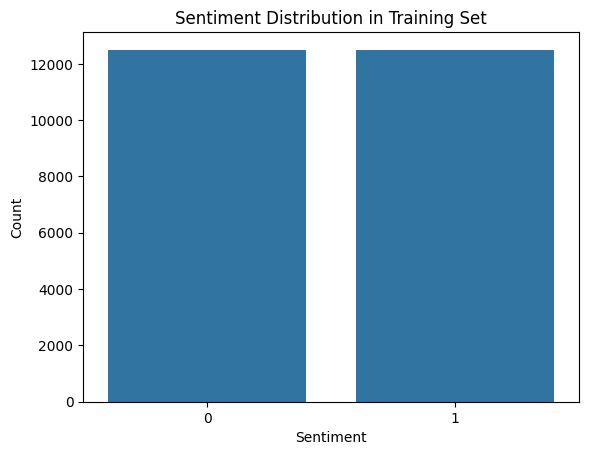

In [14]:
import seaborn as sns

# Plot the distribution of sentiments in the training set
sns.countplot(x='polarity', data=df_train)
plt.title('Sentiment Distribution in Training Set')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


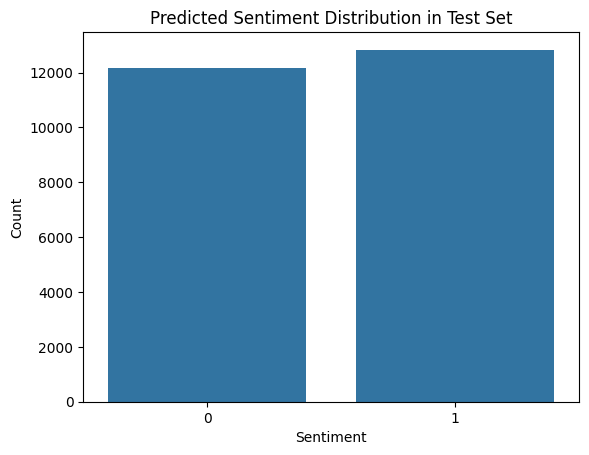

In [15]:
# Plot the distribution of predicted sentiments in the test set
sns.countplot(x='predicted_polarity', data=df_test)
plt.title('Predicted Sentiment Distribution in Test Set')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [19]:
# Top Positive and Negative Words
feature_names = tfidf.get_feature_names_out()
coef = model.layers[0].get_weights()[0]
top_positive_words = [feature_names[i] for i in coef[:,0].argsort()[-20:][::-1]]
top_negative_words = [feature_names[i] for i in coef[:,0].argsort()[:20]]

print("Top Positive Words: ", top_positive_words)
print("Top Negative Words: ", top_negative_words)

Top Positive Words:  ['unexpected', 'court', 'flaws', 'entertain', 'funniest', 'producers', 'blast', 'meant', 'enjoying', 'craven', 'haunting', 'call', 'verhoeven', 'favorite', 'sweet', 'austen', 'moved', 'hear', 'glorious', 'crew']
Top Negative Words:  ['disappointment', 'poorly', 'worst', 'missing', 'redeeming', 'screen', 'looking', 'example', 'wasted', 'lie', 'devoid', 'ugly', 'lousy', 'horrible', 'sex', 'random', 'embarrassment', 'brief', 'fallen', 'impress']
